참고 : https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko

이번 튜토리얼에서는 딥러닝을 사용하여 원하는 이미지를 다른 스타일의 이미지로 구성하는 법을 배워보겠습니다(피카소나 반 고흐처럼 그리기를 희망하나요?). 이 기법은 Neural Style Transfer로 알려져있으며, Leon A. Gatys의 논문 A Neural Algorithm of Artistic Style에 잘 기술되어 있습니다.

참고: 본 튜토리얼은 처음에 발표된 기존의 스타일 전이 알고리즘을 소개합니다. 이 알고리즘은 이미지의 콘텐츠를 특정 스타일에 최적화시키는 방식으로 작동합니다. 보다 최근에 개발된 (CycleGan과 같은) 알고리즘은 모델로 하여금 스타일이 변이된 이미지를 직접 생성하도록 만듭니다. 이 접근은 기존의 스타일 전이 알고리즘에 비해 훨씬 빠릅니다 (최대 1000배). 텐서플로 허브와 텐서플로 라이트에서는 이러한 사전 훈련된 이미지 변이 모듈을 제공하고 있습니다.

Neural style transfer은 콘텐츠 (content) 이미지와 (유명한 작가의 삽화와 같은) 스타일 참조 (style reference) 이미지를 이용하여, 콘텐츠 이미지의 콘텐츠는 유지하되 스타일 참조 이미지의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술입니다.

이 과정은 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴으로써 구현됩니다. 통계량은 합성곱 신경망을 이용해 각각의 이미지에서 추출합니다.

예시로, 아래에 주어진 강아지의 이미지와 바실리 칸딘스키의 7번 작품을 살펴봅시다:

<img src='https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'>

<img src='https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'>

<img src='https://tensorflow.org/tutorials/generative/images/stylized-image.png?hl=ko'>

모듈 구성 및 임포트

In [ ]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12) #Runtime Configuration Parameters, 줄여서 rcParams
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image #PIL : Python Imaging Library
import time
import functools #함수형 프로그래밍을 도와주는 패키지.

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor,dtype=np.uint8)
    print('dim 처리하기전의 tensor shape:',tensor.shape)
    if np.ndim(tensor)>=3:
        print(tensor.shape[0])
        assert tensor.shape[0]==1
        tensor=tensor[0]
        print('dim 처리 후 tensor shape:',tensor.shape)
    return PIL.Image.fromarray(tensor)

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


- 입력 시각화

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img) #image read
    img = tf.image.decode_image(img,channels=3)
    #Detects whether an image is  aBMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes string into a Tensor of type dtype.
    img = tf.image.convert_image_dtype(img,tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32) #텐서를 새로운 형태로 캐스팅.
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape*scale,tf.int32)

    img = tf.image.resize(img,new_shape)
    img = img[tf.newaxis,:]
    return img


- 이미지를 출력하기 위한 간단한 함수를 정의합니다.

- squeeze : 차원을 변경시키는 함수

In [ ]:
import numpy as np

arr = np.array([[1],[2],[3]])
print(arr)

[[1]
 [2]
 [3]]


In [ ]:
expansion = np.expand_dims(arr,axis=0)
print(expansion.shape)

(1, 3, 1)


In [ ]:
expansion

array([[[1],
        [2],
        [3]]])

In [ ]:
reduction = np.squeeze(arr)
print(expansion.shape)

(1, 3, 1)


In [ ]:
reduction = np.squeeze(arr,axis=1)
print(expansion.shape)

(1, 3, 1)


In [ ]:
flatten_1 = expansion.flatten()
print(flatten_1.shape)

(3,)


In [ ]:
reduction

array([1, 2, 3])

- 축 추가 :newaxis

In [ ]:
import numpy as np

arr = np.array([1,2,3,4])

print(arr)
print(arr[np.newaxis])
print(arr[:,np.newaxis])

[1 2 3 4]
[[1 2 3 4]]
[[1]
 [2]
 [3]
 [4]]


In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
    print('tf.squeeze후 shape',image.shape)

  plt.imshow(image)
  if title:
    plt.title(title)

tf.squeeze후 shape (422, 512, 3)
tf.squeeze후 shape (336, 512, 3)


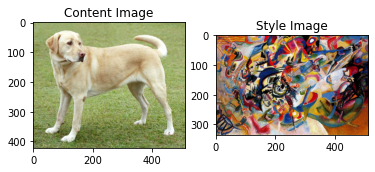

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## TF-Hub를 통한 빠른 스타일 전이

앞서 언급했듯이, 본 튜토리얼은 이미지 콘텐츠를 특정 스타일에 맞춰 최적화시키는 기존의 스타일 전이 알고리즘을 소개합니다. 이에 대해 살펴보기 전에, 텐서플로 허브 모듈은 어떤 결과물을 생성하는지 시험해봅시다:

dim 처리하기전의 tensor shape: (1, 424, 512, 3)
1
dim 처리 후 tensor shape: (424, 512, 3)


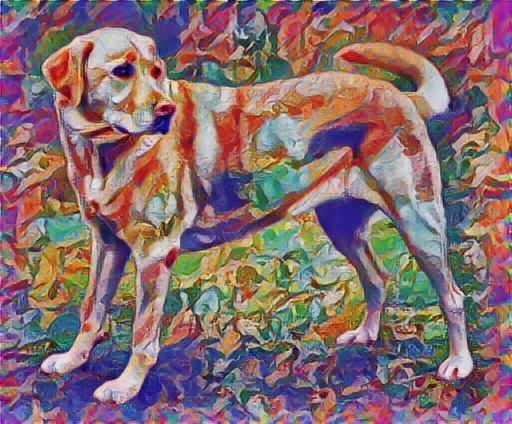

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## 콘텐츠와 스타일 표현 정의하기

이미지의 콘텐츠와 스타일 표현(representation)을 얻기 위해, 모델의 몇 가지 중간층들을 살펴볼 것입니다. 모델의 입력층부터 시작해서, 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응합니다. 반면, 네트워크가 깊어지면 최종 몇 개의 층은 바퀴나 눈과 같은 고차원적 특성들을 나타냅니다. 이번 경우, 우리는 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용할 것입니다. 이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요합니다. 입력 이미지가 주어졌을때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치시키려고 시도할 것입니다.

VGG19 모델을 불러오고, 작동 여부를 확인하기 위해 이미지에 적용시켜봅시다:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 12s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665296),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.02418277),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택합니다:

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## 스타일과 콘텐츠를 위한 중간층


그렇다면 사전훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠 표현을 정의할 수 있을까요?

고수준에서 보면 (네트워크의 훈련 목적인) 이미지 분류를 수행하기 위해서는 네트워크가 반드시 이미지를 이해햐야 합니다. 이는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내에 존재하는 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함됩니다.

또한 부분적으로 왜 합성곱(convolutional) 신경망의 일반화(generalize)가 쉽게 가능한지를 나타냅니다. 즉, 합성곱 신경망은 배경잡음(background noise)과 기타잡음(nuisances)에 상관없이 (고양이와 강아지와 같이)클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있습니다. 따라서 미가공 이미지의 입력과 분류 레이블(label)의 출력 중간 어딘가에서 모델은 복합 특성(complex feature) 추출기의 역할을 수행합니다. 그러므로, 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출할 수 있습니다.

## 모델 만들기
tf.keras.applications에서 제공하는 모델들은 케라스 함수형 API을 통해 중간층에 쉽게 접근할 수 있도록 구성되어있습니다.

함수형 API를 이용해 모델을 정의하기 위해서는 모델의 입력과 출력을 지정합니다:

model = Model(inputs, outputs)

아래의 함수는 중간층들의 결과물을 배열 형태로 출력하는 VGG19 모델을 반환합니다:

In [ ]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 336, 512, 64)
  최솟값:  0.0
  최댓값:  835.5257
  평균:  33.97525

block2_conv1
  크기:  (1, 168, 256, 128)
  최솟값:  0.0
  최댓값:  4625.886
  평균:  199.82687

block3_conv1
  크기:  (1, 84, 128, 256)
  최솟값:  0.0
  최댓값:  8789.24
  평균:  230.78104

block4_conv1
  크기:  (1, 42, 64, 512)
  최솟값:  0.0
  최댓값:  21566.135
  평균:  791.24005

block5_conv1
  크기:  (1, 21, 32, 512)
  최솟값:  0.0
  최댓값:  3189.2554
  평균:  59.179478



## 스타일 계산하기

이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다.

이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 주어진 층에 대한 그람 행렬은 다음과 같이 계산할 수 있습니다:

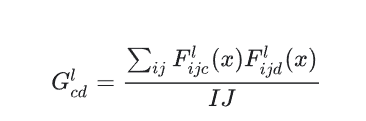

- gram matrix 참고 : https://aigong.tistory.com/360

- 따라서 style image의 output은 각 feature map의 평균과 feature들 사이의 상관관계의 정도를 정의한 Gram Matrix를 구합니다.

출처: https://junstar92.tistory.com/123 [별준 코딩]

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일과 콘텐츠 추출하기


스타일과 콘텐츠 텐서를 반환하는 모델을 만듭시다.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

이미지가 입력으로 주어졌을때, 이 모델은 style_layers의 스타일과 content_layers의 콘텐츠에 대한 그람 행렬을 출력합니다:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0055228015
    최댓값:  28014.557
    평균:  263.79022

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  61479.496
    평균:  9100.949

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  545623.44
    평균:  7660.9766

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  4320502.0
    평균:  134288.84

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  110005.36
    평균:  1487.0378

콘텐츠:
   block5_conv2
    크기:  (1, 26, 32, 512)
    최솟값:  0.0
    최댓값:  2410.8796
    평균:  13.764149


## 경사하강법 실행
이제 스타일과 콘텐츠 추출기를 사용해 스타일 전이 알고리즘을 구현할 차례입니다. 타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합을 구합니다.

스타일과 콘텐츠의 타깃값을 지정합니다:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

최적화시킬 이미지를 담을 tf.Variable을 정의하고 콘텐츠 이미지로 초기화합니다. (이때 tf.Variable는 콘텐츠 이미지와 크기가 같아야 합니다.):

In [ ]:
image = tf.Variable(content_image)

픽셀 값이 실수이므로 0과 1 사이로 클리핑하는 함수를 정의합니다:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

옵티마이저를 생성합니다. 참조 연구에서는 LBFGS를 추천하지만, Adam도 충분히 적합합니다:

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의합니다:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

tf.GradientTape를 사용해 이미지를 업데이트합니다.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

dim 처리하기전의 tensor shape: (1, 422, 512, 3)
1
dim 처리 후 tensor shape: (422, 512, 3)


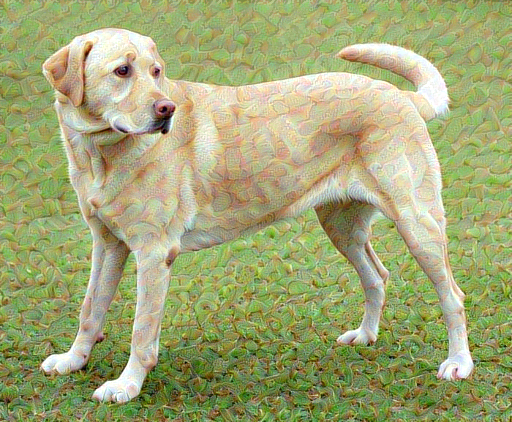

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

잘 작동하는 것을 확인했으니, 더 오랫동안 최적화를 진행해봅니다:

dim 처리하기전의 tensor shape: (1, 422, 512, 3)
1
dim 처리 후 tensor shape: (422, 512, 3)


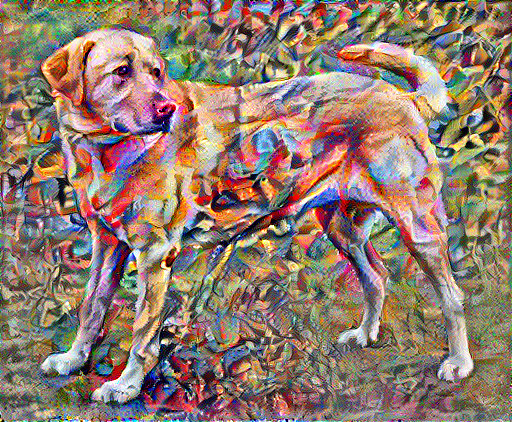

훈련 스텝: 1000
전체 소요 시간: 21.8


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))